In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Step 2: Load the Data
df = pd.read_csv("gym_floor_raw.csv")

In [3]:
# Step 3: Data Cleaning
df = df.copy()
df = df[df['GP%'] > 0]  # Remove incomplete or unsuccessful jobs (GP% = 0)

# Drop columns not relevant for modeling or highly correlated with GP%
drop_cols = ['Name', 'Account#', 'GP', 'GYMLABORAP']  # Remove 'GP' to avoid data leakage
df = df.drop(columns=drop_cols)

In [4]:
# Step 4: Encode Categorical Variables
label_enc = LabelEncoder()
df['AM'] = label_enc.fit_transform(df['AM'])

In [5]:
# Step 5: Feature/Target Split
X = df.drop(columns=['GP%'])
y = df['GP%']

In [6]:
# Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Step 7: Train Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [8]:
# Step 8: Evaluate
y_pred = rf.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R2 Score: 0.0304
RMSE: 0.0648


In [9]:
# Step 9: Feature Importance Plot
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

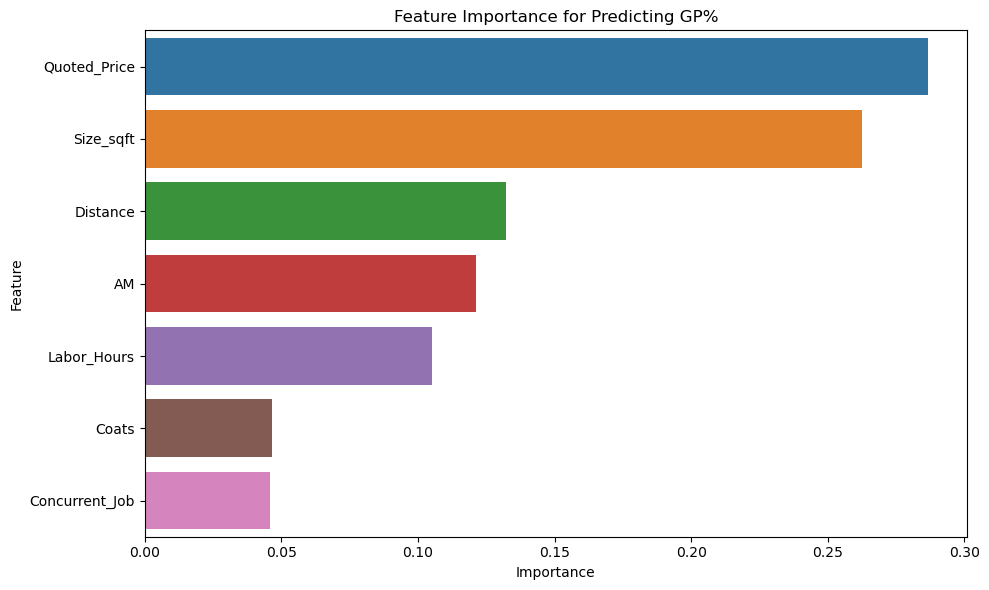

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importance for Predicting GP%")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [11]:
!pip install shap

import shap

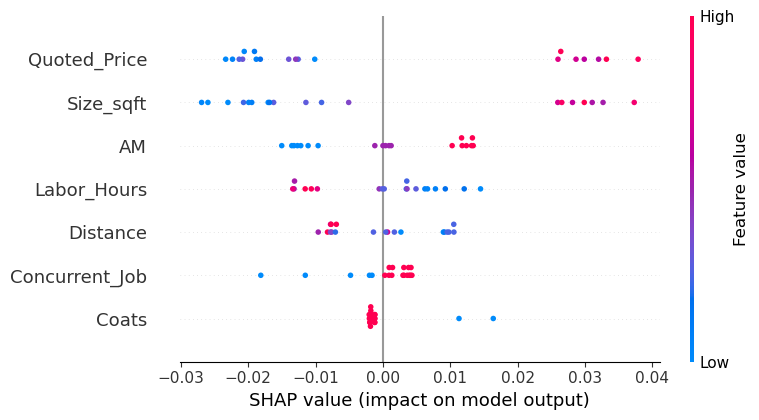

In [12]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

In [13]:
# Define a function to simulate GP% for a range of quotes
def simulate_pricing(input_data, model, target_gp=0.45, quote_range=(4000, 15000), step=100):
    """
    Simulates GP% for different quote prices to find the minimum quote that meets target GP%.

    Parameters:
        input_data: dict of job parameters excluding 'Quoted_Price'
        model: trained model
        target_gp: target gross profit percentage (e.g., 0.5)
        quote_range: (min, max) quote range to evaluate
        step: increment between quote values
    """
    import copy

    # Create dataframe from input
    base_features = pd.DataFrame([input_data])

    quotes = np.arange(quote_range[0], quote_range[1] + step, step)
    gp_preds = []

    for q in quotes:
        test_row = base_features.copy()
        test_row['Quoted_Price'] = q

        # Reorder and reindex to match model training columns
        test_row = test_row.reindex(columns=X.columns, fill_value=0)

        pred_gp = model.predict(test_row)[0]
        gp_preds.append(pred_gp)

    # Find minimum quote meeting or exceeding target GP%
    quotes = np.array(quotes)
    gp_preds = np.array(gp_preds)
    meets_target = gp_preds >= target_gp

    recommended_quote = None
    if any(meets_target):
        recommended_quote = quotes[meets_target][0]  # first price that meets goal

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(quotes, gp_preds, label="Predicted GP%")
    plt.axhline(y=target_gp, color='r', linestyle='--', label=f"Target GP%: {target_gp}")
    if recommended_quote:
        plt.axvline(x=recommended_quote, color='g', linestyle='--', label=f"Recommended Quote: ${recommended_quote}")
    plt.title("Quote vs Predicted GP%")
    plt.xlabel("Quoted Price ($)")
    plt.ylabel("Predicted GP%")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if recommended_quote:
        print(f"✅ Recommended minimum quote to meet {target_gp*100:.0f}% GP: ${recommended_quote}")
    else:
        print("❌ No quote in range meets target GP%. Consider revising job scope or cost structure.")

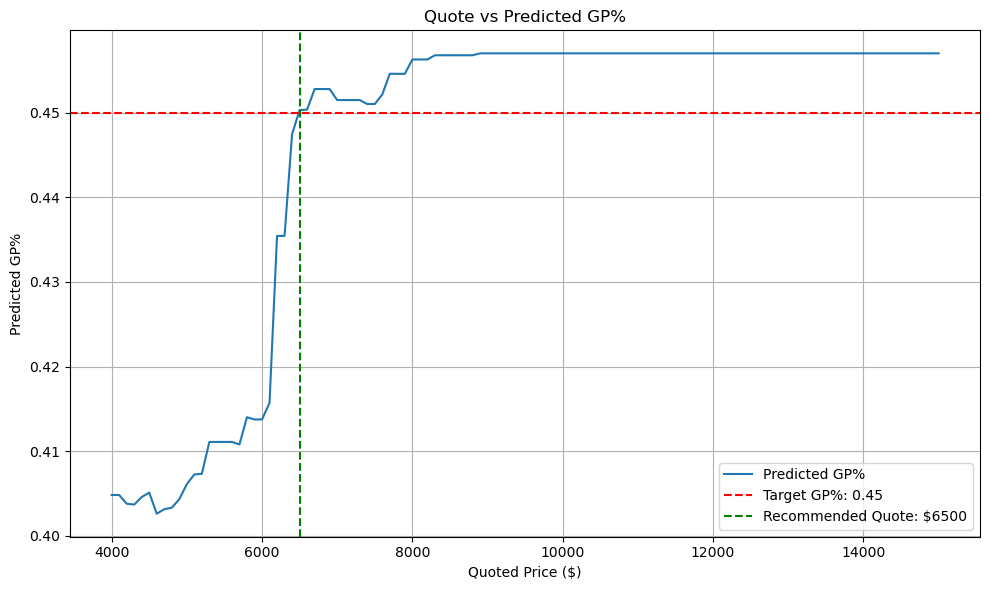

✅ Recommended minimum quote to meet 45% GP: $6500


In [14]:
job = {
    'Size_sqft': 6100,
    'Coats': 2,
    'Distance': 32,
    'Labor_Hours': 14.25,
    'AM': label_enc.transform(['Marty_Carberry'])[0],
    'Concurrent_Job': 1
}

simulate_pricing(input_data=job, model=rf, target_gp=0.45)

In [15]:
import joblib

# Train the model first (you may already have this part)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Export the trained model, label encoder, and feature list
joblib.dump(rf, 'model_rf.pkl')
joblib.dump(label_enc, 'label_encoder.pkl')
joblib.dump(list(X.columns), 'X_columns.pkl')


['X_columns.pkl']

In [16]:
import subprocess

In [17]:
notebook_name = "feature_importance.ipynb"
output_script = "feature_importance"  # no .py extension here

# Export notebook as .py script
subprocess.run([
    "jupyter", "nbconvert",
    "--to", "script",
    notebook_name,
    "--output", output_script
])

print(f"Notebook '{notebook_name}' exported to '{output_script}.py'")

Notebook 'feature_importance.ipynb' exported to 'feature_importance.py'
